In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import nltk
import io
from textblob import Word
import re
import sys, os, csv
import string
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
!pip install emot

# Data Cleaning

In [250]:
def word_prob(word): return dictionary[word] / total
def words(text): return re.findall('[a-z]+', text.lower())
dictionary = Counter(words(open('dataset/wordlists/merged.txt').read()))
max_word_length = max(map(len, dictionary))
total = float(sum(dictionary.values()))

def viterbi_segment(text):
    probs, lasts = [1.0], [0]
    for i in range(1, len(text) + 1):
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]

def fix_hashtag(text):
    text = text.group().split(":")[0]
    text = text[1:] # remove '#'
    try:
        test = int(text[0])
        text = text[1:]
    except:
        pass
    output = ' '.join(viterbi_segment(text)[0])
    return output

def prep(tweet):
    """pattern = re.compile(r"(.)\1{2,}")
    tweet = pattern.sub(r"\1\1", str(tweet))
    tweet = re.sub(r'http.?://[^\s]+[\s]?', '', str(tweet))
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct) * ' ')  # Every punctuation symbol will be replaced by a space
    tweet = tweet.translate(trantab)
    tweet = tweet.lower()
    tweet = tweet.strip()"""
    
    tweet = tweet.lower()
    tweet = re.sub("(#[A-Za-z0-9]+)", fix_hashtag, tweet)
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    tweet = re.sub('\d+', '', str(tweet))
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)     
        
    ps = PorterStemmer()
    words = tweet.split()
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    tweet = " ".join(lemma_words)
    
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = tweet.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    tweet = " ".join(clean_words)
    
    tweet = tweet.strip()
    return tweet

def vectorise_label(label):
    if label == "empty":return 0
    elif label == "sadness":return 2
    elif label == "enthusiasm":return 1
    elif label == "neutral":return 0
    elif label == "worry":return 2
    elif label == "surprise":return 1
    elif label == "love":return 3
    elif label == "fun":return 1
    elif label == "hate":return 4
    elif label == "happiness":return 1
    elif label == "boredom":return 0
    elif label == "relief":return 1
    elif label == "anger":return 4

In [ ]:
data1 = pd.read_csv("crawled_csv/processes/sad_processes.csv", sep=',', encoding='utf-8')
dataWriter = csv.writer(open('crawled_csv/prep/sad_prep.csv', 'w'), delimiter=',',lineterminator="\n")
total = 2000
for i in range(2000):
    tweet= prep(data1.iloc[:,0][i])
    dataWriter.writerow([tweet, 2])     
print("Done!")

In [225]:
count = 0
with open('crawled_csv/prep/sad_prep.csv', encoding = "utf8") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        count+=1
print(count)

2000


In [245]:
data2 = pd.read_csv('dataset/data/text_emotion.csv', sep=',', encoding='utf-8')
print("Dataset shape:",data2.shape)
print(data2.sentiment[0],":",data2.content[0])

Dataset shape: (40000, 4)
empty : @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[


In [251]:
dataWriter = csv.writer(open('cleaned_data/data_prep.csv', 'w', encoding='utf-8'), delimiter=',',lineterminator="\n")

total = 40000
for i in range(40000):
    tweet= prep(data2.content[i])
    dataWriter.writerow([tweet, str(vectorise_label(data2.sentiment[i]))])
       
print("Progress: ",100,"\nComplete!")

Progress:  100 
Complete!


In [252]:
count = 0
with open('cleaned_data/data_prep.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        count+=1
print(count)

40000


## Cleaned data file

In [38]:
data_train = pd.read_csv('cleaned_data/emotion_data_prep.csv', sep=',', encoding='utf-8')
print("Dataset shape:",data_train.shape)

Dataset shape: (62014, 2)


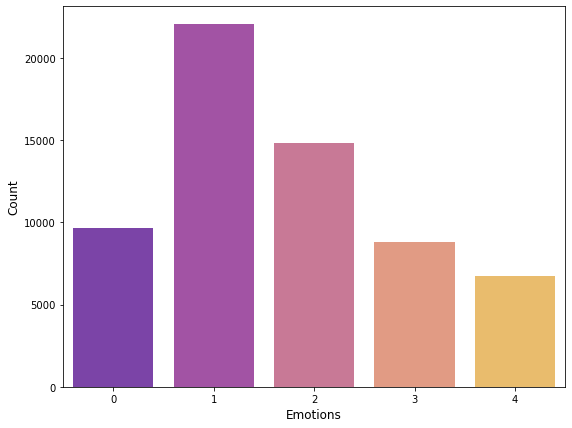

In [39]:
count  = data_train.iloc[:,1].value_counts()
plt.figure(figsize=(9,7))
sns.barplot(count.index, count.values, alpha=0.8, palette="plasma")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()
# 0 = neutral
# 1 = happy
# 2 = sad
# 3 = love
# 4 = anger

# Test Train Split

In [9]:
X_train = data_train.iloc[:,0][:49611]
#[:47583]
y_train = data_train.iloc[:,-1][:49611]
#[:47583]
X_val = data_train.iloc[:,0][49612:]
#[47584:]
y_val = data_train.iloc[:,-1][49612:]
#[47584:]

# TF-IDF Vectorizer

In [10]:
tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train.astype('U'))
X_val_tfidf = tfidf.fit_transform(X_val.astype('U'))
print(tfidf.vocabulary_)

{'go': 335, 'make': 541, 'well': 951, 'yeah': 989, 'funny': 317, 'people': 644, 'family': 260, 'book': 87, 'reading': 694, 'love': 529, 'quick': 686, 'chance': 116, 'lol': 521, 'sad': 731, 'start': 819, 'girl': 325, 'day': 176, 'sister': 781, 'bad': 54, 'time': 882, 'wow': 982, 'good': 345, 'twt': 911, 'merry': 560, 'christmas': 124, 'army': 34, 'jim': 454, 'twt merry': 912, 'merry christmas': 561, 'christmas army': 125, 'army jim': 35, 'jim merry': 455, 'twt merry christmas': 913, 'merry christmas army': 562, 'christmas army jim': 126, 'army jim merry': 36, 'jim merry christmas': 456, 'haha': 363, 'play': 660, 'fall': 259, 'boy': 92, 'bar': 57, 'full': 315, 'old': 621, 'need': 601, 'would': 981, 'ask': 40, 'really': 699, 'cut': 167, 'hang': 369, 'tomorrow': 887, 'sb': 738, 'surprise': 844, 'ver': 924, 'justin': 472, 'josh': 461, 'sejun': 758, 'sb christmas': 739, 'christmas surprise': 130, 'surprise family': 847, 'family ver': 261, 'ver merry': 925, 'christmas sb': 128, 'sb sb': 746, 

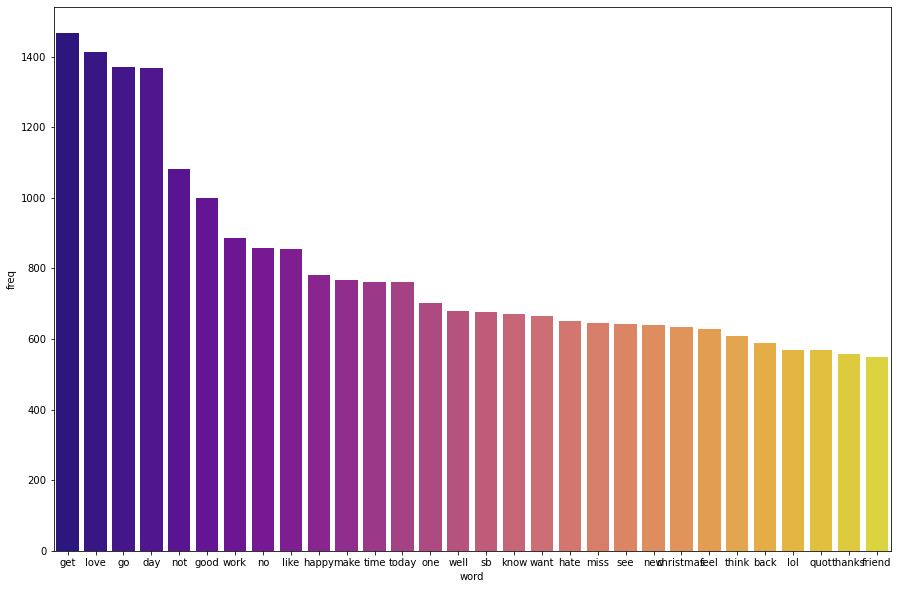

In [11]:
bow = tfidf.fit_transform(data_train.iloc[:,0].astype('U'))
word_freq = dict(zip(tfidf.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")
plt.show();

# Count Vectorizer

In [12]:
# Extracting Count Vectors Parameters
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data_train.iloc[:,0].astype('U'))
X_train_count =  count_vect.transform(X_train.astype('U'))
X_val_count =  count_vect.transform(X_val.astype('U'))
print(count_vect.vocabulary_)

{'ok': 20354, 'sound': 26605, 'goood': 11730, 'hehe': 12827, 'egg': 8756, 'holder': 13183, 'make': 17384, 'ash': 1711, 'wood': 31953, 'shop': 25631, 'link': 16632, 'wooden': 31958, 'tray': 29374, 'anniversary': 1224, 'ea': 8530, 'buy': 4251, 'book': 3485, 'review': 23966, 'help': 12888, 'get': 11375, 'amazon': 1001, 'new': 19587, 'release': 23644, 'sufi': 27500, 'poetry': 22051, 'spiritualism': 26795, 'islam': 14587, 'eeek': 8714, 'come': 5798, 'im': 13877, 'soo': 26519, 'excite': 9543, 'see': 25111, 'thursday': 28765, 'hate': 12604, 'broken': 3902, 'wrist': 32131, 'pe': 21305, 'next': 19621, 'ugh': 29957, 'sb': 24852, 'christmas': 5320, 'surprise': 27730, 'family': 9828, 'ver': 30670, 'merry': 18087, 'justin': 15267, 'josh': 15121, 'sejun': 25150, 'lol': 16834, 'nope': 19924, 'saw': 24836, 'show': 25686, 'tv': 29671, 'claimed': 5454, 'figure': 10157, 'try': 29547, 'non': 19871, 'medium': 17946, 'stats': 27069, 'guy': 12227, 'kunxx': 15953, 'royale': 24382, 'high': 13023, 'halo': 12398

(62014, 32778)


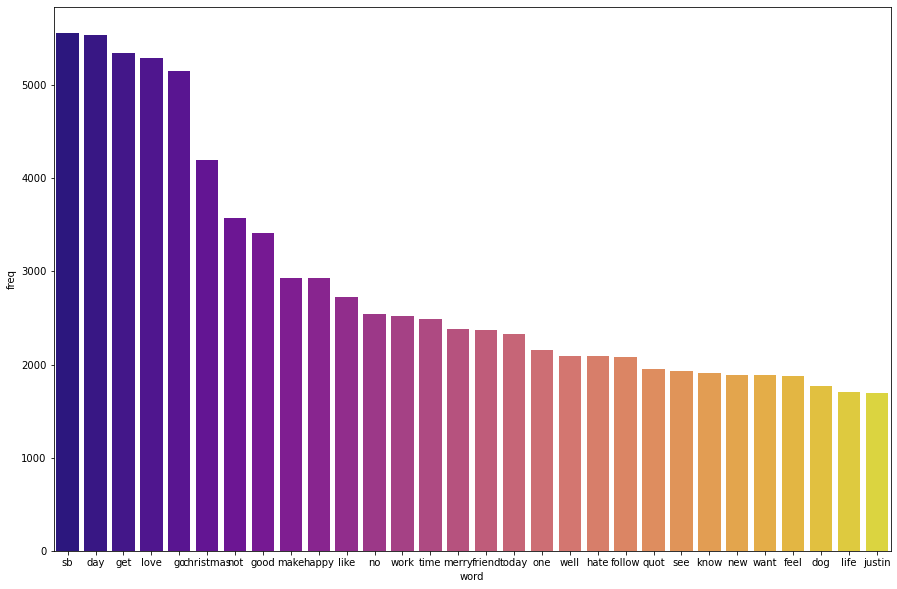

In [13]:
bow = count_vect.fit_transform(data_train.iloc[:,0].astype('U'))
print(bow.shape)
word_freq = dict(zip(count_vect.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")
plt.show();

# Building models using different classifiers (TF-IDF vectorizer)

### Model 1: Multinomial Naive Bayes Classifier

In [14]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred, y_val))
# naive bayes tfidf accuracy 0.3837284308982422

naive bayes tfidf accuracy 0.3837284308982422


### Model 2: Linear SVM

In [15]:
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred = lsvm.predict(X_val_tfidf)
print('svm using tfidf accuracy %s' % accuracy_score(y_pred, y_val))
# svm tfidf accuracy 0.38493791323980003

svm using tfidf accuracy 0.38493791323980003


### Model 3: logistic regression

In [16]:
logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_val_tfidf)
print('log reg tfidf accuracy %s' % accuracy_score(y_pred, y_val))
# log reg tfidf accuracy 0.4013868730849863

log reg tfidf accuracy 0.4013868730849863


# Building models using different classifiers (Count vectorizer)

### Model 1: Multinomial Naive Bayes Classifier

In [19]:
nb1 = MultinomialNB()
nb1.fit(X_train_count, y_train)
y_pred = nb1.predict(X_val_count)
print('naive bayes count vectors accuracy %s' % accuracy_score(y_pred, y_val))
# naive bayes count_vect accuracy 0.584663763909047

naive bayes count vectors accuracy 0.584663763909047


### Model 2: Logistic Regression

In [24]:
logreg1 = LogisticRegression(C=1, max_iter=500)
logreg1.fit(X_train_count, y_train)
y_pred = logreg1.predict(X_val_count)
print('log reg count vectors accuracy %s' % accuracy_score(y_pred, y_val))
# log reg count_vect accuracy 0.6247379454926625

log reg count vectors accuracy 0.6247379454926625


### Model 3: Linear SVM

In [34]:
lsvm1 = SGDClassifier(alpha=0.001, random_state=5, max_iter=2, tol=None)
lsvm1.fit(X_train_count, y_train)
y_pred = lsvm1.predict(X_val_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))
# svm count_vect accuracy 0.620061280438639

lsvm using count vectors accuracy 0.620061280438639


# Testing

In [22]:
tweets = pd.DataFrame(["For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find.", # happy
        "Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling.", # love
        "One day I was studying in my room when, all of a sudden, i heard hot words being exchanged between two persons in the street. I paid no attention, thinking it would be a minor quarrel but soon I heard the voices of a large number of people. I peeped from the window and saw that there was a street quarrel. I went downstairs and reached the spot in the twinkling of an eyes. I was at my wits end on seeing that both of them had come to blows. The people were standing around them and enjoying their quarrel but none tried to pacify them.", # sad
        "I am so angry at you!!!!!", # anger
        "you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop", # anger
        "I love my doggg", # love
        "I think i'm gonna be sick :'‑(", # sad
        "I hate you so much", # anger
        "I'm at work", # neutral
        "@TheTombert i was watching Harpers Island, lol... there was no vodka involved", # neutral
        "sometimes i wish things could go back to the way they were the beginning of last summer", # sad
        "it's your 18th birthday finally!!! yippeeeee", # happy
        "still waiting in line", # neutral
        "aarrgghh - fu*k.....a hose has leaked water all over the new floating floor", # anger
        "that b*tch is so ugly", # anger
        "oh no he is hospitalised!!!", # sad
       ])

tweet_count = count_vect.transform(tweets[0])

In [43]:
#Predicting the emotion of the tweet 
tweet_pred = logreg1.predict(tweet_count)
print(tweet_pred)
tweets[0]
# 0 = neutral
# 1 = happy
# 2 = sad
# 3 = love
# 4 = anger

[1 3 4 4 4 3 2 4 0 0 2 1 2 0 0 2]


0     For instance, giving a kiss to your younger si...
1     Love is the key to happiness. We all want to l...
2     One day I was studying in my room when, all of...
3                             I am so angry at you!!!!!
4     you ve hit a new low with a danger of blm fasc...
5                                       I love my doggg
6                        I think i'm gonna be sick :'‑(
7                                    I hate you so much
8                                           I'm at work
9     @TheTombert i was watching Harpers Island, lol...
10    sometimes i wish things could go back to the w...
11         it's your 18th birthday finally!!! yippeeeee
12                                still waiting in line
13    aarrgghh - fu*k.....a hose has leaked water al...
14                                that b*tch is so ugly
15                          oh no he is hospitalised!!!
Name: 0, dtype: object

In [44]:
final_result=tweets.copy()

In [45]:
final_result['result']=tweet_pred
final_result=final_result.rename(columns={0:"tweets"})
final_result=final_result.rename(columns={"result":"predicted_emotion"})
final_result=final_result.replace({0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Love', 4: 'Anger'})
final_result

,tweets,predicted_emotion
0,"For instance, giving a kiss to your younger si...",Happy
1,Love is the key to happiness. We all want to l...,Love
2,"One day I was studying in my room when, all of...",Anger
3,I am so angry at you!!!!!,Anger
4,you ve hit a new low with a danger of blm fasc...,Anger
5,I love my doggg,Love
6,I think i'm gonna be sick :'‑(,Sad
7,I hate you so much,Anger
8,I'm at work,Neutral
9,"@TheTombert i was watching Harpers Island, lol...",Neutral
